In [1]:
# for use in tutorial and development; do not include this `sys.path` change in production:
import sys ; sys.path.insert(0, "../")

# Graph algorithms with `networkx`

Once we have linked data represented as a KG, we can begin to use *graph algorithms* and *network analysis* on the data.
Perhaps the most famous of these is [PageRank](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) which helped launch Google, also known as a stochastic variant of *eigenvector centrality*.

We'll use the [`networkx`](https://networkx.org/) library to run graph algorithms, since `rdflib` lacks support for this.
Note that in `networkx` an edge connects two nodes, where both nodes and edges may have properties.
This is effectively a [*property graph*](https://en.wikipedia.org/wiki/Graph_database#Labeled-property_graph).
In contrast, an RDF graph in `rdflib` allows for multiple relations (predicates) between RDF subjects and objects, although there are no values represented.
Also, `networkx` requires its own graph representation in memory.

Based on a branch of mathematics related to linear algebra called [*algebraic graph theory*](https://en.wikipedia.org/wiki/Algebraic_graph_theory), it's possible to convert between a simplified graph (such as `networkx` requires) and its matrix representation.
Many of the popular graph algorithms can be optimized in terms of matrix operations – often leading to orders of magnitude in performance increases.
In contrast, the more general form of mathematics for representing complex graphs and networks involves using [*tensors*](https://en.wikipedia.org/wiki/Tensor) instead of matrices.
For example, you may have heard that word `tensor` used in association with neural networks?

See also:

  * <https://towardsdatascience.com/10-graph-algorithms-visually-explained-e57faa1336f3>
  * <https://web.stanford.edu/class/cs97si/06-basic-graph-algorithms.pdf>
  * <https://networkx.org/documentation/stable/reference/algorithms/index.html>

First, let's load our recipe KG:

In [2]:
import kglab

namespaces = {
    "nom":  "http://example.org/#",
    "wtm":  "http://purl.org/heals/food/",
    "ind":  "http://purl.org/heals/ingredient/",
    "skos": "http://www.w3.org/2004/02/skos/core#",
    }

kg = kglab.KnowledgeGraph(
    name = "A recipe KG example based on Food.com",
    base_uri = "https://www.food.com/recipe/",
    namespaces = namespaces,
    )

kg.load_rdf("../dat/recipes.ttl")

The `kglab.Subgraph` class transform graph data from the symbolic representation of an RDF graph into a numerical representation which is an *adjacency matrix*.
Most graph algorithm libraries such as `NetworkX` use an *adjacency matrix* representation internally.

Later we'll use the inverse transform in `Subgraph` to convert graph algorithm results back into their symbolic represenation.

In [3]:
import networkx as nx

subgraph = kglab.Subgraph(kg)
nx_graph = nx.DiGraph()

Next, we'll run a SPARQL query to use in building a *subgraph* of recipe URLs and their related ingredients.

Note the bindings `subject` and `object` – for *subject* and *object* respectively.
The `Subgraph` class expects these in the results of a SPARQL query used to generate a representation for `NetworkX`.

In [4]:
sparql = """
    SELECT ?subject ?object
    WHERE {
        ?subject rdf:type wtm:Recipe .
        ?subject wtm:hasIngredient ?object .
    }
    """

Next, use the result set from this query to load the `NetworkX` subgraph.
Formally speaking, all RDF graphs are *directed graphs* since the semantics of RDF connect a *subject* through a *predicate* to an *object*.
We use a [`DiGraph`](https://networkx.org/documentation/stable/reference/classes/digraph.html?highlight=digraph#networkx.DiGraph) for a *directed graph*.

Note: the `bipartite` parameter identifies the subject and object nodes to be within one of two *bipartite* sets – which we'll describe in more detail below.

In [5]:
for row in kg.query(sparql):
    s_id = subgraph.transform(row.subject)
    s_label = subgraph.n3fy(row.subject)

    o_id = subgraph.transform(row.object)
    o_label = subgraph.n3fy(row.object)

    #print("{}: {}\n {}: {}\n".format(s_id, s_label, o_id, o_label))

    nx_graph.add_node(s_id, bipartite=0)
    nx_graph.add_node(o_id, bipartite=1)
    nx_graph.add_edge(s_id, o_id)

## Graph measures

One simple measure in `networkx` is to use the [`density()`](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.density.html) method to calculate [*graph density*](http://olizardo.bol.ucla.edu/classes/soc-111/textbook/_book/6-9-graph-density.html).
This is a ratio of the edges in the graph to the maximum possible number of edges it could have.
A *dense graph* will tend toward a density measure of the `1.0` upper bound, while a *sparse graph* will tend toward the `0.0` lower bound.

In [6]:
nx.density(nx_graph)

0.016513480392156863

While interpretations of the *density* metric depends largely on context, here we could say that the recipe-ingredient relations in our recipe KG are relatively sparse.

To perform some kinds of graph analysis and traversals, you may need convert the *directed graph* to an *undirected graph*.
For example, the following code uses [`bfs_edges()`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.traversal.breadth_first_search.bfs_edges.html#networkx.algorithms.traversal.breadth_first_search.bfs_edges) to perform a *bread-first search* (BFS) beginning at a starting node `source` and search out to a maximum of `depth_limit` hops as a boundary.

We'll use `butter` as the starting node, which is a common ingredient and therefore should have many neighbors. In other words, collect the most immediate "neighbors" for `butter` from the graph:

In [7]:
butter_node = kg.get_ns("ind").Butter
butter_id = subgraph.transform(butter_node)

edges = list(nx.bfs_edges(nx_graph, source=butter_id, depth_limit=2))
print("num edges:", len(edges))

num edges: 0


Zero. No edges were returned, and thus no neighbors were identified by BFS.

So far within the recipe representation in our KG, the `butter` ingredient is a *terminal node*, i.e., other nodes connect to it as an *object*.
However, it never occurs as the *subject* of an RDF triple so `butter` in turn does not connect into any other nodes in a *directed graph* – it's a dead-end.

Now let's use the `to_undirected()` method to convert to an *undirected graph* first, then run the same BFS again:

In [8]:
for edge in nx.bfs_edges(nx_graph.to_undirected(), source=butter_id, depth_limit=2):
    s_id, o_id = edge

    s_node = subgraph.inverse_transform(s_id)
    s_label = subgraph.n3fy(s_node)

    o_node = subgraph.inverse_transform(o_id)
    o_label = subgraph.n3fy(o_node)

    # for brevity's sake, only show non-butter nodes
    if s_node != butter_node:
        print(s_label, o_label)

<https://www.food.com/recipe/200871> ind:ChickenEgg
<https://www.food.com/recipe/200871> ind:CowMilk
<https://www.food.com/recipe/200871> ind:AllPurposeFlour
<https://www.food.com/recipe/200871> ind:WhiteSugar
<https://www.food.com/recipe/200871> ind:Water
<https://www.food.com/recipe/94616> ind:VanillaExtract
<https://www.food.com/recipe/109179> ind:Salt
<https://www.food.com/recipe/482308> ind:BlackPepper
<https://www.food.com/recipe/45057> ind:AppleCiderVinegar
<https://www.food.com/recipe/80546> ind:OliveOil
<https://www.food.com/recipe/437607> ind:WholeWheatFlour
<https://www.food.com/recipe/138985> ind:BrownSugar
<https://www.food.com/recipe/426449> ind:Honey
<https://www.food.com/recipe/104441> ind:Garlic


Among the closest neighbors for `butter` we find `salt`, `milk`, `flour`, `sugar`, `honey`, `vanilla`, etc.
BFS is a relatively quick and useful approach for building discovery tools and recommender systems to explore neighborhoods of a graph.

Given how we've built this subgraph, it has two distinct and independent sets of nodes – namely, the *recipes* and the *ingredients*.
In other words, recipes only link to ingredients, and ingredients only link to recipes.
This structure fits the formal definitions of a [*bipartite graph*](https://en.wikipedia.org/wiki/Bipartite_graph), which is important for working AI applications such as recommender systems, search engines, etc.  Let's decompose our subgraph into its two sets of nodes:

In [9]:
from networkx.algorithms import bipartite

rec_nodes, ind_nodes = bipartite.sets(nx_graph)

print("recipes\n", rec_nodes, "\n")
print("ingredients\n", ind_nodes)

recipes
 {0, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226, 227, 228, 229, 230, 231,

If you remove the `if` statement from the BFS example above that filters output, you may notice some "shapes" or *topology* evident in the full listing of neighbors. In other words, BFS search expands out as `butter` connects to a set of recipes, then those recipes connect to other ingredients, and in turn those ingredients connect to an even broader set of other recipes.

We can measure some of the simpler, more common topologies in the graph by using the [`triadic_census()`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.triads.triadic_census.html#networkx.algorithms.triads.triadic_census) method, which identifies and counts the occurrences of *dyads* and *triads*:

In [10]:
for triad, occurrances in nx.triadic_census(nx_graph).items():
    if occurrances > 0:
        print("triad {:>4}: {:7d} occurrences".format(triad, occurrances))

triad  003: 2564784 occurrances
triad  012:  123660 occurrances
triad 021D:    2025 occurrances
triad 021U:   73051 occurrances


See "Figure 1" in [[batageljm01]](https://derwen.ai/docs/kgl/biblio/#batageljm01) for discussion about how to decode this output from `triadic_census()` based on the 16 possible forms of triads.
In this case, we see many occurrences of `021D` and `021U` triads, which is expected in a bipartite graph.

## Centrality and connectedness

Let's make good use of those bipartite sets for filtering results from other algorithms.

Some of the ingredients are used more frequently than others.
In very simple graphs we could use statistical frequency counts to measure that, although a more general purpose approach is to measure the *degree centrality*, i.e., "How connected is each node?"
This is similar to calculating PageRank:

In [11]:
results = nx.degree_centrality(nx_graph)
ind_rank = {}

for node_id, rank in sorted(results.items(), key=lambda item: item[1], reverse=True):
    if node_id in ind_nodes:
        ind_rank[node_id] = rank
        node = subgraph.inverse_transform(node_id)
        label = subgraph.n3fy(node)
        print("{:6.3f} {}".format(rank, label))

 0.745 ind:AllPurposeFlour
 0.667 ind:ChickenEgg
 0.620 ind:Salt
 0.576 ind:Butter
 0.518 ind:CowMilk
 0.388 ind:WhiteSugar
 0.275 ind:Water
 0.212 ind:VanillaExtract
 0.059 ind:BlackPepper
 0.043 ind:BrownSugar
 0.035 ind:WholeWheatFlour
 0.035 ind:OliveOil
 0.024 ind:AppleCiderVinegar
 0.012 ind:Bacon
 0.012 ind:Honey
 0.008 ind:Garlic


We can plot the graph directly from `networkx` using [`matplotlib`](https://matplotlib.org/):

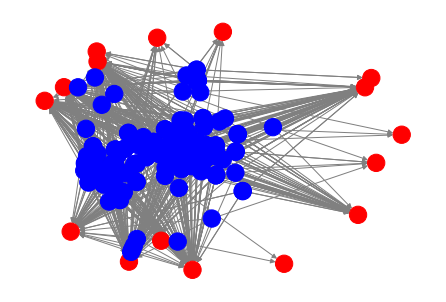

In [12]:
import matplotlib.pyplot as plt

color = [ "red" if n in ind_nodes else "blue" for n in nx_graph.nodes()]

nx.draw(nx_graph, node_color=color, edge_color="gray", with_labels=False)
plt.show()

Next, let's determine the [*k-cores*](https://en.wikipedia.org/wiki/Degeneracy_(graph_theory)#k-Cores) which are "maximal connected subgraphs" such that each node has `k` connections:

In [13]:
core_g = nx.k_core(nx_graph)
core_g.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 9, 11, 13, 14, 17, 149, 25, 26, 29, 158, 163, 169, 173, 179, 53, 182, 183, 56, 57, 192, 69, 201, 202, 80, 213, 89, 92, 93, 224, 97, 98, 100, 105, 235, 243, 117, 245, 248, 122))

Now let's plot those k-core nodes in a simplified visualization, which helps reveal the interconnections:

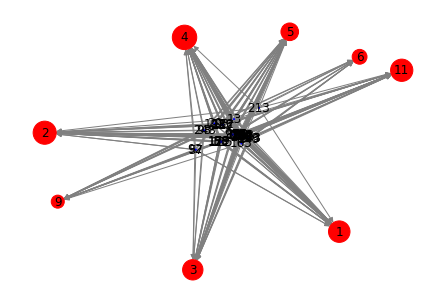

In [14]:
color = [ "red" if n in ind_nodes else "blue" for n in core_g ]
size = [ ind_rank[n] * 800 if n in ind_nodes else 1 for n in core_g ]

nx.draw(core_g, node_color=color, node_size=size, edge_color="gray", with_labels=True)
plt.show()

In [15]:
for node_id, rank in sorted(ind_rank.items(), key=lambda item: item[1], reverse=True):
    if node_id in core_g:
        node = subgraph.inverse_transform(node_id)
        label = subgraph.n3fy(node)
        print("{:3} {:6.3f} {}".format(node_id, rank, label))

  4  0.745 ind:AllPurposeFlour
  2  0.667 ind:ChickenEgg
 11  0.620 ind:Salt
  1  0.576 ind:Butter
  3  0.518 ind:CowMilk
  5  0.388 ind:WhiteSugar
  6  0.275 ind:Water
  9  0.212 ind:VanillaExtract


In other words, as the popular ingredients for recipes in our graph tend to be: `flour`, `eggs`, `salt`, `butter`, `milk`, `sugar` – although not so much `water` or `vanilla`.

We can show a similar ranking with PageRank, although with different weights:

In [16]:
page_rank = nx.pagerank(nx_graph)

for node_id, rank in sorted(ind_rank.items(), key=lambda item: item[1], reverse=True):
    if node_id in core_g:
        node = subgraph.inverse_transform(node_id)
        label = subgraph.n3fy(node)
        print("{:3} {:6.3f} {:6.3f} {}".format(node_id, rank, page_rank[node_id], label))

  4  0.745  0.082 ind:AllPurposeFlour
  2  0.667  0.072 ind:ChickenEgg
 11  0.620  0.066 ind:Salt
  1  0.576  0.062 ind:Butter
  3  0.518  0.055 ind:CowMilk
  5  0.388  0.042 ind:WhiteSugar
  6  0.275  0.034 ind:Water
  9  0.212  0.022 ind:VanillaExtract


---

## Exercises

**Exercise 1:**
    
Find the `node_id` number for the node that represents the `"black pepper"` ingredient.

Then use the [`bfs_edges()`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.traversal.breadth_first_search.bfs_edges.html#networkx.algorithms.traversal.breadth_first_search.bfs_edges) function with its source set to `node_id` to perform a *breadth first search* traversal of the graph to depth `2` to find the closest neighbors and print their labels.

**Exercise 2:**

Use the [`dfs_edges()`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.traversal.depth_first_search.dfs_edges.html#networkx.algorithms.traversal.depth_first_search.dfs_edges) function to perform a *depth first search* with the same parameters.

**Exercise 3:**

Find the [*shortest path*](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html) that connects between the node for "black pepper" and the node for "honey", then print the labels for each node in the path.